Cell 1: Imports & Config

In [1]:
# === 1) Imports & Config ===
# All code comments are in English.

import os
from pathlib import Path
import re
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---- File paths (change to your local files if needed) ----
DATA_TS = Path("../data/IBM_HR_timeseries.csv")
DATA_PERSONA = Path("../data/IBM_HR_personas_assigned.csv")

# ---- Columns to EXCLUDE from modeling (user-specified) ----
EXCLUDED_COLS = {
    "focused_ratio",
    "meeting_collaboration_ratio",
    "social_dining_ratio",
    "break_relaxation_ratio",
    "shared_work_ratio",
}

# ---- Reproducibility ----
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# ---- Device ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [ ]:
# === 2) Preprocessing: build monthly panel (2023-01..2024-12) → tensor (N, T=24, F) & labels ===

def detect_date_col(df: pd.DataFrame) -> str:
    # Pick common names first; else a mostly-parsable datetime column
    common = {'date','record_date','timestamp','dt','day','month','period'}
    for c in df.columns:
        if c.lower() in common: 
            return c
    for c in df.columns:
        try:
            p = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
            if p.notna().mean() > 0.7:
                return c
        except Exception:
            pass
    raise ValueError("No date-like column found.")

def detect_emp_id(df: pd.DataFrame) -> str:
    # Regex on common employee id names
    pats = r'(^employee[_\s-]*id$)|(^emp.*id$)|(^employeenumber$)|(^worker[_-]*id$)'
    for c in df.columns:
        if re.search(pats, c, flags=re.I):
            return c
    # Fallback: reasonable cardinality
    nun = df.nunique(dropna=False)
    candidates = nun[(nun>10) & (nun < max(11, len(df)//2))].index.tolist()
    return candidates[0] if candidates else df.columns[0]

def to_binary_attrition(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in ("yes","y","true","1"): return 1
    if s in ("no","n","false","0"): return 0
    try:
        return int(float(s))
    except:
        return np.nan

# ---- Load ----
ts = pd.read_csv(DATA_TS)
persona = pd.read_csv(DATA_PERSONA)

# ---- Detect keys ----
emp_col_ts = detect_emp_id(ts)
date_col = detect_date_col(ts)

# Persona: pick the column with max overlap to time-series employee ids
ts_ids = set(ts[emp_col_ts].astype(str).unique())
best_col, best_overlap = None, -1.0
for c in persona.columns:
    overlap = len(ts_ids.intersection(set(persona[c].astype(str).unique()))) / max(1, len(ts_ids))
    if overlap > best_overlap:
        best_overlap, best_col = overlap, c
emp_col_persona = best_col

# Attrition column
attr_cands = [c for c in persona.columns if c.lower() in ("attrition","churn","resigned","left_company")]
if not attr_cands:
    attr_cands = [c for c in persona.columns if "attrition" in c.lower()]
assert attr_cands, "No 'attrition' column found in personas."
attr_col = attr_cands[0]

print(f"Detected columns: emp_col_ts='{emp_col_ts}', emp_col_persona='{emp_col_persona}', date_col='{date_col}', attr_col='{attr_col}'")

# ---- Monthly panel (2023-01 .. 2024-12) ----
ts = ts.copy()
ts[date_col] = pd.to_datetime(ts[date_col], errors='coerce', infer_datetime_format=True)
ts = ts.dropna(subset=[date_col])
ts['month'] = ts[date_col].dt.to_period('M').dt.to_timestamp()

start = pd.Timestamp("2023-01-01"); end = pd.Timestamp("2024-12-31")
ts = ts[(ts['month']>=start) & (ts['month']<=end)]

# ---- Numeric columns, exclude user-specified ratio columns and keys ----
exclude = {emp_col_ts, date_col, 'month'} | EXCLUDED_COLS
num_cols = [c for c in ts.columns if c not in exclude and np.issubdtype(ts[c].dtype, np.number)]
# Try coercion for numeric-like strings (safety)
for c in list(num_cols):
    if not np.issubdtype(ts[c].dtype, np.number):
        ts[c] = pd.to_numeric(ts[c], errors='coerce')
# Drop all-NaN columns
num_cols = [c for c in num_cols if ts[c].notna().any()]

print("Using numeric features (excluded specified ratio columns):")
print(num_cols)

# ---- Aggregate to employee-month mean ----
agg = ts.groupby([emp_col_ts,'month'])[num_cols].mean().reset_index()

# ---- Reindex to full 24 months per employee ----
all_months = pd.date_range(start=start, end=end, freq='MS')
panels = []
for emp, g in agg.groupby(emp_col_ts):
    g = g.set_index('month').reindex(all_months)
    g[emp_col_ts] = emp
    panels.append(g.reset_index().rename(columns={'index':'month'}))
panel = pd.concat(panels, ignore_index=True).sort_values([emp_col_ts,'month'])

# ---- Fill within employee (ffill/bfill then zeros) ----
for c in num_cols:
    panel[c] = panel.groupby(emp_col_ts)[c].ffill().bfill()
panel[num_cols] = panel[num_cols].fillna(0.0)

# ---- Build tensor (N, T=24, F) ----
employees = panel[emp_col_ts].drop_duplicates().tolist()
T = len(all_months); F = len(num_cols)
X_seq = np.zeros((len(employees), T, F), dtype=np.float32)
emp_to_idx = {e:i for i,e in enumerate(employees)}
for e, g in panel.groupby(emp_col_ts):
    i = emp_to_idx[e]
    g = g.sort_values('month')
    X_seq[i, :, :] = g[num_cols].values.astype(np.float32)

# ---- Labels ----
labels = persona[[emp_col_persona, attr_col]].copy()
labels['attrition_bin'] = labels[attr_col].apply(to_binary_attrition).astype('Int64')
labels = labels.dropna(subset=['attrition_bin']).rename(columns={emp_col_persona: emp_col_ts})
label_map = labels.set_index(emp_col_ts)['attrition_bin'].to_dict()
y = np.array([int(label_map.get(e, np.nan)) for e in employees])
mask = ~np.isnan(y)
X_seq = X_seq[mask]; y = y[mask].astype(int)
employees = [e for e,m in zip(employees, mask) if m]

print("Final tensor (N, T, F):", X_seq.shape)
print("Class balance:", {int(k):int(v) for k,v in pd.Series(y).value_counts().to_dict().items()})

Detected columns: emp_col_ts='employee_id', emp_col_persona='EmployeeNumber', date_col='date', attr_col='Attrition'


C:\Users\jsjon\AppData\Local\Temp\ipykernel_24016\3509783793.py:67: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts[date_col] = pd.to_datetime(ts[date_col], errors='coerce', infer_datetime_format=True)


Using numeric features (excluded specified ratio columns):
['day_of_week', 'day_index', 'work_focused_ratio', 'system_login_hours', 'work_focused_hours', 'meeting_collaboration_hours', 'social_dining_hours', 'break_relaxation_hours', 'shared_work_hours', 'internal_comm_volume', 'cafeteria_usage', 'convenience_food_usage']
Final tensor (N, T, F): (1470, 24, 12)
Class balance: {0: 1233, 1: 237}


In [3]:
# === 3) Employee-level Train/Test split + scaling ===

groups = np.array(employees)

# Group-aware split (avoid leakage across employees)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_idx, test_idx = next(cv.split(X_seq, y, groups=groups))

X_train, y_train = X_seq[train_idx], y[train_idx]
X_test,  y_test  = X_seq[test_idx],  y[test_idx]
emp_train = [employees[i] for i in train_idx]
emp_test  = [employees[i] for i in test_idx]

# Validation split from train (stratified)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_STATE)
tr_idx, va_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
X_va, y_va = X_train[va_idx], y_train[va_idx]

# Standardize features based on train only (flatten time axis)
F = X_tr.shape[2]
scaler = StandardScaler()
scaler.fit(X_tr.reshape(-1, F))
X_tr = scaler.transform(X_tr.reshape(-1, F)).reshape(X_tr.shape)
X_va = scaler.transform(X_va.reshape(-1, F)).reshape(X_va.shape)
X_test = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

print("Train/Val/Test sizes:", X_tr.shape[0], X_va.shape[0], X_test.shape[0])


Train/Val/Test sizes: 999 177 294


In [4]:
# === 4) Dataset & Models (GRU / 1D-CNN) ===

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                          dropout=0.0 if num_layers==1 else dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):  # x: [B, T, F]
        out, h = self.gru(x)        # h: [num_layers, B, H]
        h_last = h[-1]              # [B, H]
        z = self.dropout(h_last)
        return self.fc(z).squeeze(1)

class CNN1DClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super().__init__()
        # Expect input as [B, F, T]
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):  # x: [B, T, F]
        x = x.permute(0, 2, 1)      # -> [B, F, T]
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)  # [B, H]
        x = self.dropout(x)
        return self.fc(x).squeeze(1)


In [6]:
# === 5) Training utilities + Train + Predict ===

def get_class_weight_pos(y_np: np.ndarray) -> float:
    # Positive class weight = (#neg / #pos)
    pos = (y_np == 1).sum()
    neg = (y_np == 0).sum()
    return float(neg / max(1, pos)) if pos > 0 else 1.0

def train_model(model, X_tr, y_tr, X_va, y_va, epochs=40, lr=1e-3, batch_size=64, patience=8):
    # Early stopping by validation F1
    train_ds = SeqDataset(X_tr, y_tr)
    val_ds   = SeqDataset(X_va, y_va)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    pos_weight = get_class_weight_pos(y_tr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=DEVICE))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_state = None
    best_f1 = -1.0
    no_improve = 0

    model = model.to(DEVICE)
    for epoch in range(1, epochs+1):
        # Train
        model.train()
        tr_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logit = model(xb)
            loss = criterion(logit, yb)
            loss.backward()
            optimizer.step()
            tr_losses.append(loss.item())

        # Validate
        model.eval()
        with torch.no_grad():
            yv_true, yv_prob = [], []
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                logit = model(xb)
                prob = torch.sigmoid(logit).cpu().numpy()
                yv_prob.append(prob)
                yv_true.append(yb.numpy())
            yv_true = np.concatenate(yv_true)
            yv_prob = np.concatenate(yv_prob)
            yv_pred = (yv_prob >= 0.5).astype(int)
            f1 = f1_score(yv_true, yv_pred, zero_division=0)

        print(f"Epoch {epoch:02d} | train_loss={np.mean(tr_losses):.4f} | val_f1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping!")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict_proba(model, X):
    ds = SeqDataset(X, np.zeros(len(X)))
    loader = DataLoader(ds, batch_size=256, shuffle=False)
    model.eval()
    probs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            p = torch.sigmoid(model(xb)).cpu().numpy()
            probs.append(p)
    return np.concatenate(probs)

# ---- Choose and train model ----
MODEL_TYPE = "gru"   # change to "cnn" to use 1D-CNN

input_dim = X_tr.shape[2]
if MODEL_TYPE.lower() == "gru":
    model = GRUClassifier(input_dim=input_dim, hidden_dim=64, num_layers=1, dropout=0.1)
elif MODEL_TYPE.lower() == "cnn":
    model = CNN1DClassifier(input_dim=input_dim, hidden_dim=64, dropout=0.1)
else:
    raise ValueError("MODEL_TYPE must be 'gru' or 'cnn'")

model = train_model(model, X_tr, y_tr, X_va, y_va, epochs=40, lr=1e-3, batch_size=64, patience=8)

# ---- Predict on test ----
proba_test = predict_proba(model, X_test)
pred_test = (proba_test >= 0.5).astype(int)

Epoch 01 | train_loss=1.1638 | val_f1=0.2261
Epoch 02 | train_loss=1.1467 | val_f1=0.2299
Epoch 03 | train_loss=1.1418 | val_f1=0.2273
Epoch 04 | train_loss=1.1363 | val_f1=0.2326
Epoch 05 | train_loss=1.1294 | val_f1=0.2472
Epoch 06 | train_loss=1.1346 | val_f1=0.2418
Epoch 07 | train_loss=1.1254 | val_f1=0.2222
Epoch 08 | train_loss=1.1210 | val_f1=0.2174
Epoch 09 | train_loss=1.1137 | val_f1=0.2245
Epoch 10 | train_loss=1.1115 | val_f1=0.2022
Epoch 11 | train_loss=1.1093 | val_f1=0.2198
Epoch 12 | train_loss=1.1026 | val_f1=0.2000
Epoch 13 | train_loss=1.1103 | val_f1=0.2222
Early stopping!


{'Accuracy': 0.5748, 'Precision': 0.1885, 'Recall': 0.4694, 'F1': 0.269, 'ROC_AUC': 0.5458, 'PR_AUC': 0.1873}


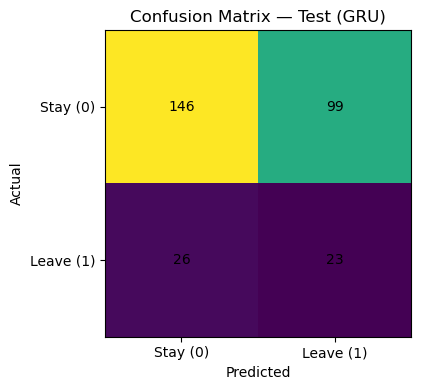


Classification report (test):

              precision    recall  f1-score   support

           0     0.8488    0.5959    0.7002       245
           1     0.1885    0.4694    0.2690        49

    accuracy                         0.5748       294
   macro avg     0.5187    0.5327    0.4846       294
weighted avg     0.7388    0.5748    0.6284       294

Saved: ./seq_scaler.joblib, ./seq_model_gru.pt, ./seq_predictions_test.csv


In [ ]:
# === 6) Evaluation (and optional save) ===

metrics = {
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test, zero_division=0),
    "Recall": recall_score(y_test, pred_test, zero_division=0),
    "F1": f1_score(y_test, pred_test, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, proba_test) if len(np.unique(y_test))>1 else np.nan,
    "PR_AUC": average_precision_score(y_test, proba_test) if len(np.unique(y_test))>1 else np.nan
}
print({k: (round(v,4) if isinstance(v, float) and not np.isnan(v) else v) for k,v in metrics.items()})

# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=[0,1])
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix — Test ({MODEL_TYPE.upper()})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Stay (0)", "Leave (1)"])
plt.yticks([0,1], ["Stay (0)", "Leave (1)"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center')
plt.tight_layout()
plt.show()

print("\nClassification report (test):\n")
print(classification_report(y_test, pred_test, digits=4))

# ---- Optional: save artifacts to current directory ----
try:
    import joblib
    joblib.dump({"scaler": scaler, "feature_names": list(range(X_tr.shape[2]))}, "./seq_scaler.joblib")
    torch.save(model.state_dict(), f"./seq_model_{MODEL_TYPE}.pt")
    pd.DataFrame({
        "employee_id": np.array(emp_test),
        "attrition_true": y_test,
        "attrition_proba": proba_test,
        "attrition_pred": pred_test
    }).to_csv("./seq_predictions_test.csv", index=False)
    print("Saved: ./seq_scaler.joblib, ./seq_model_%s.pt, ./seq_predictions_test.csv" % MODEL_TYPE)
except Exception as e:
    print("Save skipped due to:", e)

In [8]:
# === A) Why so fast? Quick diagnostics ===
print("Train N:", X_tr.shape[0], "Val N:", X_va.shape[0], "Test N:", X_test.shape[0])
print("Sequence length T:", X_tr.shape[1], "Feature dim F:", X_tr.shape[2])
print("Class balance (train):", {int(k): int(v) for k, v in pd.Series(y_tr).value_counts().to_dict().items()})

# Check how many epochs actually ran (look for 'Early stopping!' in logs)
# If you want to force longer training:
FORCE_LONGER_TRAINING = False
if FORCE_LONGER_TRAINING:
    # Re-train with larger epochs/patience just to see it run longer
    MODEL_TYPE = "gru"  # or "cnn"
    input_dim = X_tr.shape[2]
    model_long = GRUClassifier(input_dim, hidden_dim=128, num_layers=2, dropout=0.3) if MODEL_TYPE=="gru" \
                 else CNN1DClassifier(input_dim, hidden_dim=128, dropout=0.3)
    model_long = train_model(model_long, X_tr, y_tr, X_va, y_va,
                             epochs=200, lr=1e-3, batch_size=32, patience=20)

Train N: 999 Val N: 177 Test N: 294
Sequence length T: 24 Feature dim F: 12
Class balance (train): {0: 839, 1: 160}


In [9]:
# === B) Threshold tuning on validation (maximize F1) ===
# Need predicted probabilities on validation
proba_val = predict_proba(model, X_va)

ths = np.linspace(0.05, 0.95, 19)
best_f1, best_th = -1.0, 0.5
for th in ths:
    pred_val = (proba_val >= th).astype(int)
    f1 = f1_score(y_va, pred_val, zero_division=0)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"Best threshold on val: {best_th:.2f} (F1={best_f1:.4f})")

# Apply to test
proba_test = predict_proba(model, X_test)  # recompute to be explicit
pred_test_opt = (proba_test >= best_th).astype(int)

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, average_precision_score
cm = confusion_matrix(y_test, pred_test_opt, labels=[0,1])
print("Confusion matrix @th=%.2f\n%s" % (best_th, cm))
print("\nPrecision:", round(precision_score(y_test, pred_test_opt, zero_division=0),4),
      "Recall:", round(recall_score(y_test, pred_test_opt, zero_division=0),4),
      "F1:", round(f1_score(y_test, pred_test_opt, zero_division=0),4))
try:
    print("ROC-AUC:", round(roc_auc_score(y_test, proba_test),4),
          "PR-AUC:", round(average_precision_score(y_test, proba_test),4))
except:
    pass


Best threshold on val: 0.35 (F1=0.2786)
Confusion matrix @th=0.35
[[  7 238]
 [  0  49]]

Precision: 0.1707 Recall: 1.0 F1: 0.2917
ROC-AUC: 0.5458 PR-AUC: 0.1873


In [10]:
# === C1) Train with softer positive weight (alpha<1) ===
def train_model_weighted(model, X_tr, y_tr, X_va, y_va, epochs=40, lr=1e-3, batch_size=64, patience=8, alpha=0.5):
    train_ds = SeqDataset(X_tr, y_tr); val_ds = SeqDataset(X_va, y_va)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    base = (y_tr==0).sum() / max(1,(y_tr==1).sum())
    pos_weight = torch.tensor(base**alpha, device=DEVICE)  # soften weight
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_state, best_f1, no_improve = None, -1.0, 0
    model = model.to(DEVICE)
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad(); loss = criterion(model(xb), yb); loss.backward(); optimizer.step()
        # val
        model.eval()
        yv_true, yv_prob = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yv_prob.append(torch.sigmoid(model(xb)).cpu().numpy())
                yv_true.append(yb.numpy())
        yv_true = np.concatenate(yv_true); yv_prob = np.concatenate(yv_prob)
        f1 = f1_score(yv_true, (yv_prob>=0.5).astype(int), zero_division=0)
        print(f"Epoch {epoch:02d} | val_f1={f1:.4f} | pos_weight={pos_weight.item():.3f}")
        if f1>best_f1: best_f1, best_state, no_improve = f1, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
        else:
            no_improve += 1
            if no_improve >= patience: print("Early stopping!"); break
    if best_state is not None: model.load_state_dict(best_state)
    return model

# Re-train quickly with softened weight
MODEL_TYPE = "gru"
input_dim = X_tr.shape[2]
model_soft = GRUClassifier(input_dim, hidden_dim=64, num_layers=1, dropout=0.1) if MODEL_TYPE=="gru" \
             else CNN1DClassifier(input_dim, hidden_dim=64, dropout=0.1)
model_soft = train_model_weighted(model_soft, X_tr, y_tr, X_va, y_va, epochs=40, alpha=0.6)
proba_test_soft = predict_proba(model_soft, X_test)
# You can also apply the tuned threshold from Cell B


Epoch 01 | val_f1=0.0571 | pos_weight=2.703
Epoch 02 | val_f1=0.0000 | pos_weight=2.703
Epoch 03 | val_f1=0.0000 | pos_weight=2.703
Epoch 04 | val_f1=0.0000 | pos_weight=2.703
Epoch 05 | val_f1=0.0000 | pos_weight=2.703
Epoch 06 | val_f1=0.0000 | pos_weight=2.703
Epoch 07 | val_f1=0.0000 | pos_weight=2.703
Epoch 08 | val_f1=0.1143 | pos_weight=2.703
Epoch 09 | val_f1=0.1143 | pos_weight=2.703
Epoch 10 | val_f1=0.1081 | pos_weight=2.703
Epoch 11 | val_f1=0.1143 | pos_weight=2.703
Epoch 12 | val_f1=0.1111 | pos_weight=2.703
Epoch 13 | val_f1=0.1500 | pos_weight=2.703
Epoch 14 | val_f1=0.1538 | pos_weight=2.703
Epoch 15 | val_f1=0.1500 | pos_weight=2.703
Epoch 16 | val_f1=0.1500 | pos_weight=2.703
Epoch 17 | val_f1=0.1538 | pos_weight=2.703
Epoch 18 | val_f1=0.1429 | pos_weight=2.703
Epoch 19 | val_f1=0.1333 | pos_weight=2.703
Epoch 20 | val_f1=0.1500 | pos_weight=2.703
Epoch 21 | val_f1=0.2083 | pos_weight=2.703
Epoch 22 | val_f1=0.1818 | pos_weight=2.703
Epoch 23 | val_f1=0.1887 | pos_w

In [ ]:
# === C2) (대안) Focal Loss로 재학습 — FP 줄이기 시도 ===
class FocalLossBCEWithLogits(nn.Module):
    def __init__(self, gamma=2.0, pos_weight=None):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        p = torch.sigmoid(logits)
        pt = torch.where(targets==1, p, 1-p).clamp_min(1e-6)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

def train_model_focal(model, X_tr, y_tr, X_va, y_va, epochs=40, lr=1e-3, batch_size=64, patience=8, gamma=2.0):
    train_ds = SeqDataset(X_tr, y_tr); val_ds = SeqDataset(X_va, y_va)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    base = (y_tr==0).sum() / max(1,(y_tr==1).sum())
    criterion = FocalLossBCEWithLogits(gamma=gamma, pos_weight=torch.tensor(base, device=DEVICE))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_state, best_f1, no_improve = None, -1.0, 0
    model = model.to(DEVICE)
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            loss = criterion(model(xb), yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        # val
        model.eval()
        yv_true, yv_prob = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yv_prob.append(torch.sigmoid(model(xb)).cpu().numpy())
                yv_true.append(yb.numpy())
        yv_true = np.concatenate(yv_true); yv_prob = np.concatenate(yv_prob)
        f1 = f1_score(yv_true, (yv_prob>=0.5).astype(int), zero_division=0)
        print(f"Epoch {epoch:02d} | val_f1={f1:.4f}")
        if f1>best_f1: best_f1, best_state, no_improve = f1, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
        else:
            no_improve += 1
            if no_improve >= patience: print("Early stopping!"); break
    if best_state is not None: model.load_state_dict(best_state)
    return model

# 사용 예
# model_focal = GRUClassifier(input_dim=X_tr.shape[2], hidden_dim=64)
# model_focal = train_model_focal(model_focal, X_tr, y_tr, X_va, y_va, gamma=2.0)